In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, Bidirectional, Dropout, SpatialDropout1D

plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
train = pd.read_csv('Toxic_Multi/train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.drop(columns = ['id'], axis = 1, inplace = True)

In [6]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train[train['comment_text'] == ' ']

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [8]:
X =  train['comment_text']
y =  train.drop(['comment_text'],axis = 1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [10]:
# using keras tokenizer

max_len = 1500
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(X_train) + list(X_test))

X_train_seq = token.texts_to_sequences(X_train)
X_test_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

word_index = token.word_index

## RNN

In [9]:
model_rnn = Sequential()
model_rnn.add(Embedding(len(word_index) + 1, 300, input_length = max_len))
model_rnn.add(SimpleRNN(100))
model_rnn.add(Dense(6, activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         63101400  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 63,142,106
Trainable params: 63,142,106
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_history = model_rnn.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test), epochs=2, batch_size = 128)

Epoch 1/2
873/873 [==============================] - 2586s 3s/step - loss: 0.1016 - accuracy: 0.9664 - val_loss: 0.0835 - val_accuracy: 0.9912
Epoch 2/2
873/873 [==============================] - 2483s 3s/step - loss: 0.0673 - accuracy: 0.9767 - val_loss: 0.0694 - val_accuracy: 0.9934


In [11]:
rnn_loss, rnn_acc = model_rnn.evaluate(X_test_pad, y_test)
print(f"Loss :- {rnn_loss}, Accuracy :- {rnn_acc}")

1496/1496 [==============================] - 496s 332ms/step - loss: 0.0694 - accuracy: 0.9934
Loss :- 0.06942811608314514, Accuracy :- 0.9934199452400208


In [12]:
rnn_preds = model_rnn.predict(X_test_pad)

1496/1496 [==============================] - 501s 335ms/step


In [13]:
y_test.head(20)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
74251,0,0,0,0,0,0
131406,1,0,0,0,0,0
120969,0,0,0,0,1,0
121827,0,0,0,0,0,0
4771,0,0,0,0,0,0
79050,0,0,0,0,0,0
86098,0,0,0,0,0,0
55703,0,0,0,0,0,0
113939,0,0,0,0,0,0
19481,0,0,0,0,0,0


In [14]:
rnn_preds = pd.DataFrame(rnn_preds)
rnn_preds.head(20)

,0,1,2,3,4,5
0,0.003714,0.000456,0.001289,0.000476,0.001047,0.000573
1,0.097200,0.001734,0.008414,0.001706,0.018767,0.004709
2,0.092314,0.003688,0.025565,0.002550,0.028445,0.006530
3,0.017589,0.000589,0.002067,0.001215,0.004009,0.001562
4,0.031512,0.000869,0.005345,0.000640,0.006799,0.001739
5,0.002028,0.000438,0.001535,0.000377,0.000640,0.000725
6,0.181713,0.002368,0.018722,0.002359,0.034932,0.005610
7,0.002767,0.000569,0.001476,0.000595,0.000808,0.000831
8,0.014002,0.000746,0.003690,0.000467,0.004322,0.001138
9,0.006823,0.000483,0.001543,0.000656,0.001923,0.000599


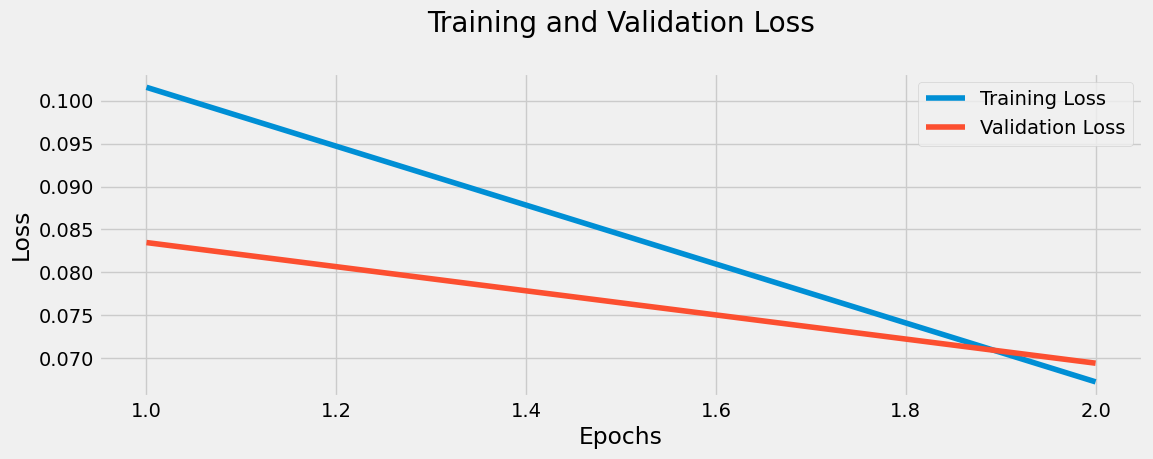

In [15]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 3)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

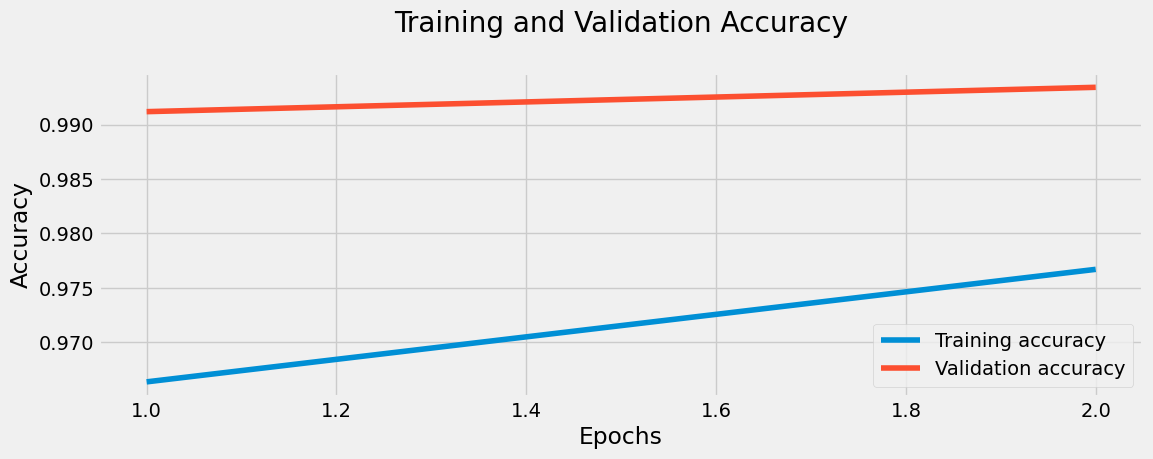

In [16]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 3)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### LSTM

In [9]:
model_lstm = Sequential()
model_lstm.add(Embedding(len(word_index) + 1, 300 , input_length = max_len))
model_lstm.add(CuDNNLSTM(100))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(6, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         63101400  
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 100)               160800    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 63,262,806
Trainable params: 63,262,806
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model_history = model_lstm.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test),epochs = 3, batch_size = 64)

Epoch 1/5
1746/1746 [==============================] - 256s 141ms/step - loss: 0.0741 - accuracy: 0.9084 - val_loss: 0.0492 - val_accuracy: 0.9938
Epoch 2/5
1746/1746 [==============================] - 249s 142ms/step - loss: 0.0435 - accuracy: 0.9699 - val_loss: 0.0481 - val_accuracy: 0.9938
Epoch 3/5
1746/1746 [==============================] - 239s 137ms/step - loss: 0.0328 - accuracy: 0.9769 - val_loss: 0.0523 - val_accuracy: 0.9924
Epoch 4/5
1746/1746 [==============================] - 254s 145ms/step - loss: 0.0255 - accuracy: 0.9257 - val_loss: 0.0568 - val_accuracy: 0.9784
Epoch 5/5
1746/1746 [==============================] - 252s 145ms/step - loss: 0.0200 - accuracy: 0.8442 - val_loss: 0.0617 - val_accuracy: 0.8935


In [11]:
lstm_loss, lstm_acc = model_lstm.evaluate(X_test_pad, y_test)

1496/1496 [==============================] - 37s 24ms/step - loss: 0.0617 - accuracy: 0.8935


In [ ]:
lstm_preds = model_lstm.predict(X_test_pad)

In [ ]:
y_test.head(20)

In [ ]:
rnn_preds = pd.DataFrame(lstm_preds)
rnn_preds.head()

In [ ]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 4)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 4)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### GRU

In [11]:
## Creating model

model_gru=Sequential()
model_gru.add(Embedding(len(word_index) + 1, 300 , input_length=max_len))
model_gru.add(SpatialDropout1D(0.3))
model_gru.add(CuDNNGRU(300))
model_gru.add(Dense(6, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         63101400  
                                                                 
 spatial_dropout1d (SpatialD  (None, 1500, 300)        0         
 ropout1D)                                                       
                                                                 
 cu_dnngru (CuDNNGRU)        (None, 300)               541800    
                                                                 
 dense (Dense)               (None, 6)                 1806      
                                                                 
Total params: 63,645,006
Trainable params: 63,645,006
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
model_history = model_gru.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test), epochs=5, batch_size = 64)

Epoch 1/5
1746/1746 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9845

In [ ]:
gru_loss, gru_acc = model_gru.evaluate(X_test_pad, y_test)

In [ ]:
gru_preds = model_gru.predict(X_test_pad)

In [ ]:
y_test.head(20)

In [ ]:
gru_preds = pd.DataFrame(gru_preds)
gru_preds.head(20)

In [ ]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 4)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 4)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Bidirectional LSTM

In [ ]:
## Creating model

model_bilstm=Sequential()
model_bilstm.add(Embedding(len(word_index) + 1, 300 , input_length=max_len))
model_bilstm.add(Bidirectional(LSTM(300)))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Dense(6, activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_bilstm.summary())

In [ ]:
model_history = model_gru.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test), epochs=3, batch_size = 64)

In [ ]:
bilstm_loss, bilstm_acc = model_bilstm.evaluate(X_test_pad, y_test)

In [ ]:
bilstm_preds = model_bilstm.predict(X_test_pad)

In [ ]:
y_test.head(20)

In [ ]:
bilstm_preds = pd.DataFrame(bilstm_preds)
bilstm_preds.head(20)

In [ ]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 4)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 4)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()